In [1]:
from collections import OrderedDict

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

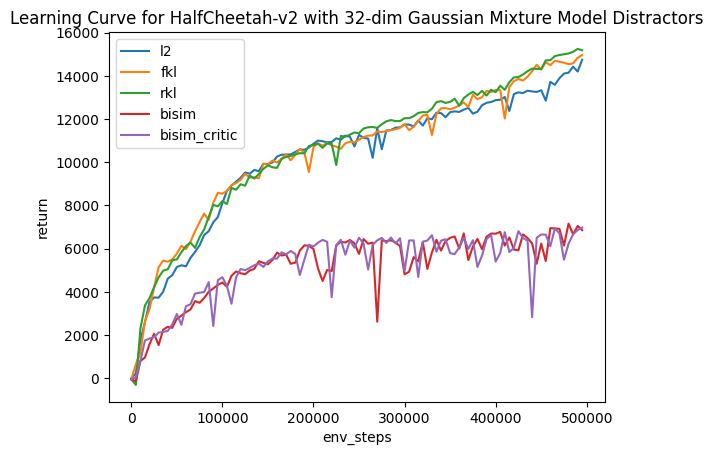

In [2]:
datasets = OrderedDict(
    [
        (
            "l2",
            "./logs/HalfCheetah-v2-d32/2024-10-09-14-50-30+1930320-1930320/progress.csv",
        ),
        (
            "fkl",
            "./logs/HalfCheetah-v2-d32/2024-10-09-14-48-19+1926785-1926785/progress.csv",
        ),
        (
            "rkl",
            "./logs/HalfCheetah-v2-d32/2024-10-09-14-50-12+1929748-1929748/progress.csv",
        ),
        (
            "bisim",
            "./logs/HalfCheetah-v2-d32/2024-10-09-14-48-21+1926890-1926890/progress.csv",
        ),
        (
            "bisim_critic",
            "./logs/HalfCheetah-v2-d32/2024-10-09-17-47-38+27493-27493/progress.csv",
        ),
    ]
)

for name, file_name in datasets.items():
    df = pd.read_csv(file_name)
    df = df[~df["return"].isna()]

    plt.plot(df["env_steps"], df["return"])

plt.title(
    "Learning Curve for HalfCheetah-v2 with 32-dim Gaussian Mixture Model Distractors"
)
plt.xlabel("env_steps")
plt.ylabel("return")
plt.legend(datasets.keys())
plt.show()

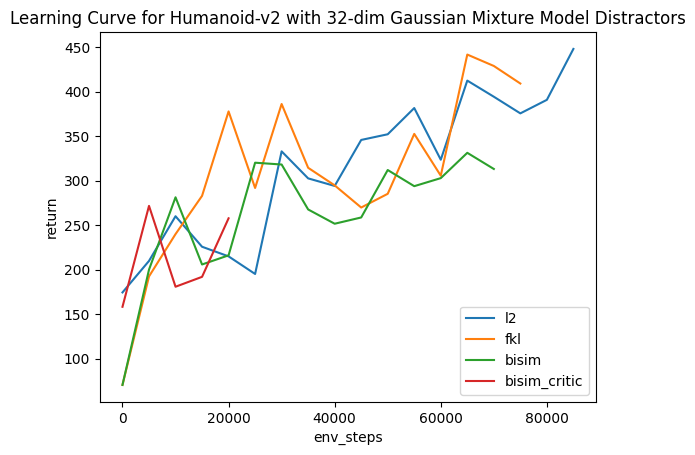

In [3]:
datasets = OrderedDict(
    [
        (
            "l2",
            "./logs/Humanoid-v2-d32/2024-10-10-00-05-20+12467-12467/progress.csv",
        ),
        (
            "fkl",
            "./logs/Humanoid-v2-d32/2024-10-10-00-04-13+10923-10923/progress.csv",
        ),
        (
            "bisim",
            "./logs/Humanoid-v2-d32/2024-10-10-00-04-24+10982-10982/progress.csv",
        ),
        (
            "bisim_critic",
            "./logs/Humanoid-v2-d32/2024-10-10-00-05-00+11755-11755/progress.csv",
        ),
    ]
)

for name, file_name in datasets.items():
    df = pd.read_csv(file_name)
    df = df[~df["return"].isna()]

    plt.plot(df["env_steps"], df["return"])

plt.title(
    "Learning Curve for Humanoid-v2 with 32-dim Gaussian Mixture Model Distractors"
)
plt.xlabel("env_steps")
plt.ylabel("return")
plt.legend(datasets.keys())
plt.show()

In [4]:
datasets = OrderedDict(
    [
        (
            "bisim_critic_15",
            "./logs/BipedalWalker-v3/2024-10-10-12-54-00+34348-34348/progress.csv",
        ),
        (
            "bisim_critic_challenger",
            "./logs/BipedalWalker-v3/2024-10-11-23-32-24+54874-54874/progress.csv",
        ),
        (
            "bisim_critic_gamma_5e-3",
            "./logs/BipedalWalker-v3/2024-10-12-11-23-24+69174-69174/progress.csv",
        ),
    ]
)

for name, file_name in datasets.items():
    df = pd.read_csv(file_name)
    df = df[~df["return"].isna()]

    plt.plot(df["env_steps"], df["return"])

plt.title("Learning Curve for BipedalWalker-v3")
plt.xlabel("env_steps")
plt.ylabel("return")
plt.legend(datasets.keys())
plt.show()

IsADirectoryError: [Errno 21] Is a directory: './logs/BipedalWalker-v3/2024-10-10-12-54-00+34348-34348/'

In [ ]:
df = pd.read_csv(datasets["bisim_critic_challenger"])
df = df[
    # ~df['return'].isna()
      ~df["aux_loss"].isna()
    & ~df["bisim_critic_loss"].isna()
    & ~df["alm_loss"].isna()
    & ~df["critic_loss"].isna()
]
plt.subplot(2, 1, 1)
plt.plot(df['env_steps'], df['r_dist'])
plt.plot(df['env_steps'], df['transition_dist'] * 0.1)
# plt.plot(df['env_steps'], df['bisimilarity'])
# plt.legend(['r_dist', 'transition_dist', 'bisimilarity'])

plt.subplot(2, 1, 2)
plt.plot(df['env_steps'], df['z_dist'])
plt.show()

In [ ]:
df = pd.read_csv(datasets["bisim_critic_gamma_5e-3"])
df = df[
    # ~df['return'].isna()
      ~df["aux_loss"].isna()
    & ~df["bisim_critic_loss"].isna()
    & ~df["alm_loss"].isna()
    & ~df["critic_loss"].isna()
]
plt.subplot(2, 1, 1)
plt.plot(df['env_steps'], df['r_dist'])
plt.plot(df['env_steps'], df['transition_dist'] * 0.005)
# plt.plot(df['env_steps'], df['bisimilarity'])
# plt.legend(['r_dist', 'transition_dist', 'bisimilarity'])

plt.subplot(2, 1, 2)
plt.plot(df['env_steps'], df['z_dist'])
plt.show()

In [ ]:
df = pd.read_csv(datasets["bisim_critic_15"])
df = df[
    ~df["aux_loss"].isna()
    & ~df["bisim_critic_loss"].isna()
    & ~df["alm_loss"].isna()
    & ~df["critic_loss"].isna()
]

plt.figure(figsize=(10, 6))

plt.subplot(3, 1, 1)
plt.plot(df["env_steps"], df["alm_loss"])
plt.plot(df["env_steps"], df["aux_loss"])
plt.xlabel("env_steps")
plt.ylabel("loss")
plt.title("Total Encoder Loss")
plt.legend(["alm_loss", "aux_loss"])

plt.subplot(3, 1, 2)
plt.plot(df["env_steps"], df["bisim_critic_loss"])
plt.xlabel("env_steps")
plt.ylabel("loss")
plt.title("Bisim Critic Loss")

plt.subplot(3, 1, 3)
plt.plot(df["env_steps"], df["critic_loss"])
plt.xlabel("env_steps")
plt.ylabel("loss")
plt.title("Agent Critic Loss")

plt.show()

In [ ]:
fkl_d32_gmm_df = pd.read_csv(
    "logs/Ant-v2-d32/2024-10-08-14-37-29+5513-5513/progress.csv"
)
fkl_d32_gmm_df = fkl_d32_gmm_df[~fkl_d32_gmm_df["return"].isna()]

bisim_d32_gmm_df = pd.read_csv(
    "logs/Ant-v2-d32/2024-10-08-14-37-48+6123-6123/progress.csv"
)
bisim_d32_gmm_df = bisim_d32_gmm_df[~bisim_d32_gmm_df["return"].isna()]

bisim_d32_gmm_df

In [ ]:
plt.plot(fkl_d32_gmm_df["env_steps"], fkl_d32_gmm_df["return"])
plt.plot(bisim_d32_gmm_df["env_steps"], bisim_d32_gmm_df["return"])
plt.title("Learning Curve for Ant-v2 with 32-dim Gaussian Mixture Model Distractors")
plt.xlabel("env_steps")
plt.ylabel("return")
plt.legend(["fkl", "bisim"])
plt.show()